## Problem Statement

<div class="alert alert-warning">
    <strong>We intend to predict whether any given individual is likely to have diabetes using the dataset we obtained from Kaggle which contains 768 data of diabetics and non-diabetic individuals.<br><br>
        Factors include:<br>
        1) Pregnancies<br>
        2) Glucose<br>
        3) Blood Pressure <br>
        4) Skin Thickness <br>
        5) Insulin <br>
        6) BMI <br>
        7) Diabetes Pedigree Function [indicates the function which scores likelihood of diabetes based on family history]<br>
        8) Age <br>
        9) Diabetic Outcome<br>
    </strong>

</div>

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.utils import resample,shuffle
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv("diabetes.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


---
## Improving Data By Further Cleaning

In [3]:
#Check for NULL data
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
#Correlation between Variables
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


<div class="alert alert-warning">
    <strong>The dataset contains data filled with integer "0" which signifies NULL. We decided to replace "0"s with NaN.</strong>

</div>



In [5]:
#Replace "0" data with NULL and find the number of NULL for each variable
data[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = data[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].replace(0, np.NaN)
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<div class="alert alert-warning">
    <strong>We decided to drop Insulin and SkinThickness from dataset as there are too many missing data for the variables. We realised there is not much correlation with the diabetes outcome. <br><br>Although blood pressure correlation is low, it have very little missing data. Thus, by replacing it with median might improve the correlation.</strong>

</div>

In [6]:
#Drop Insulin and SkinThickness as explained above.
data = data.drop(["Insulin", "SkinThickness"], axis =1)

In [7]:
#Get the median values
data.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
#Replace zero values in Glucose, BMI, Bloodpressure with median values
data["Glucose"] = data["Glucose"].replace(np.NaN, 117)
data["BMI"] = data["BMI"].replace(np.NaN, 32.3)
data["BloodPressure"] = data["BloodPressure"].replace(np.NaN, 72)
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<div class="alert alert-warning">
    <strong>We replaced the NaN value with median because the outliers will affect the mean.<br>
We don't use mode because it is not a frequency (discrete value) but a continous data.</strong>

</div>




---
## Exploratory Analysis & Data Visualisation

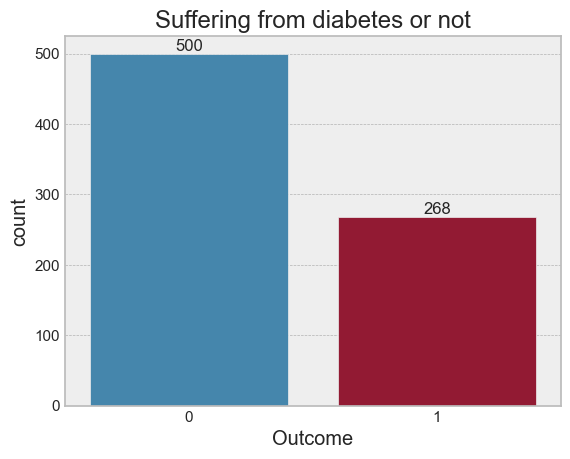

In [9]:
#Count of number of persons suffering diabetes
plt.style.use('bmh')
ax = sb.countplot(x= data.Outcome , data= data)
ax.bar_label(ax.containers[0])
ax.set_title('Suffering from diabetes or not')
plt.show()

<div class="alert alert-warning">
    <strong>We used the appropriate plots to visualize the data for each variable.</strong>

</div>


<AxesSubplot:title={'center':'Counter Plot'}, xlabel='Age', ylabel='count'>

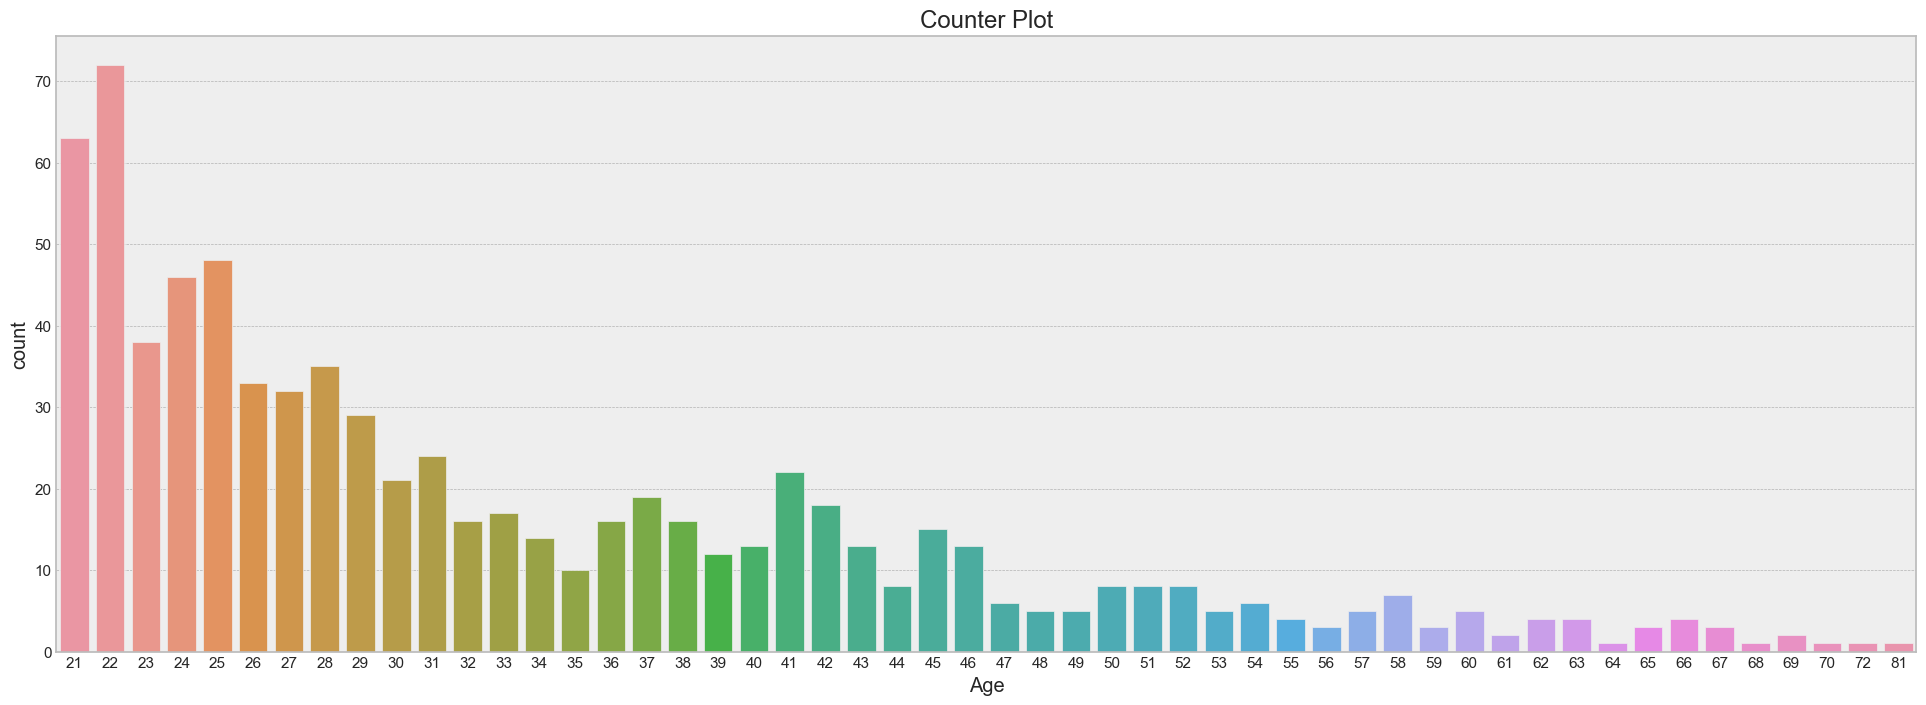

In [10]:
#Age
plt.figure(figsize=(24,8))

plt.title("Counter Plot")
sb.countplot(x = 'Age',data = data)

#plt.subplot(1,3,3)
#plt.title('Outcome Box Plot')
#sb.catplot(data = data, x="Age", y="Outcome", kind="box", orient = "h")

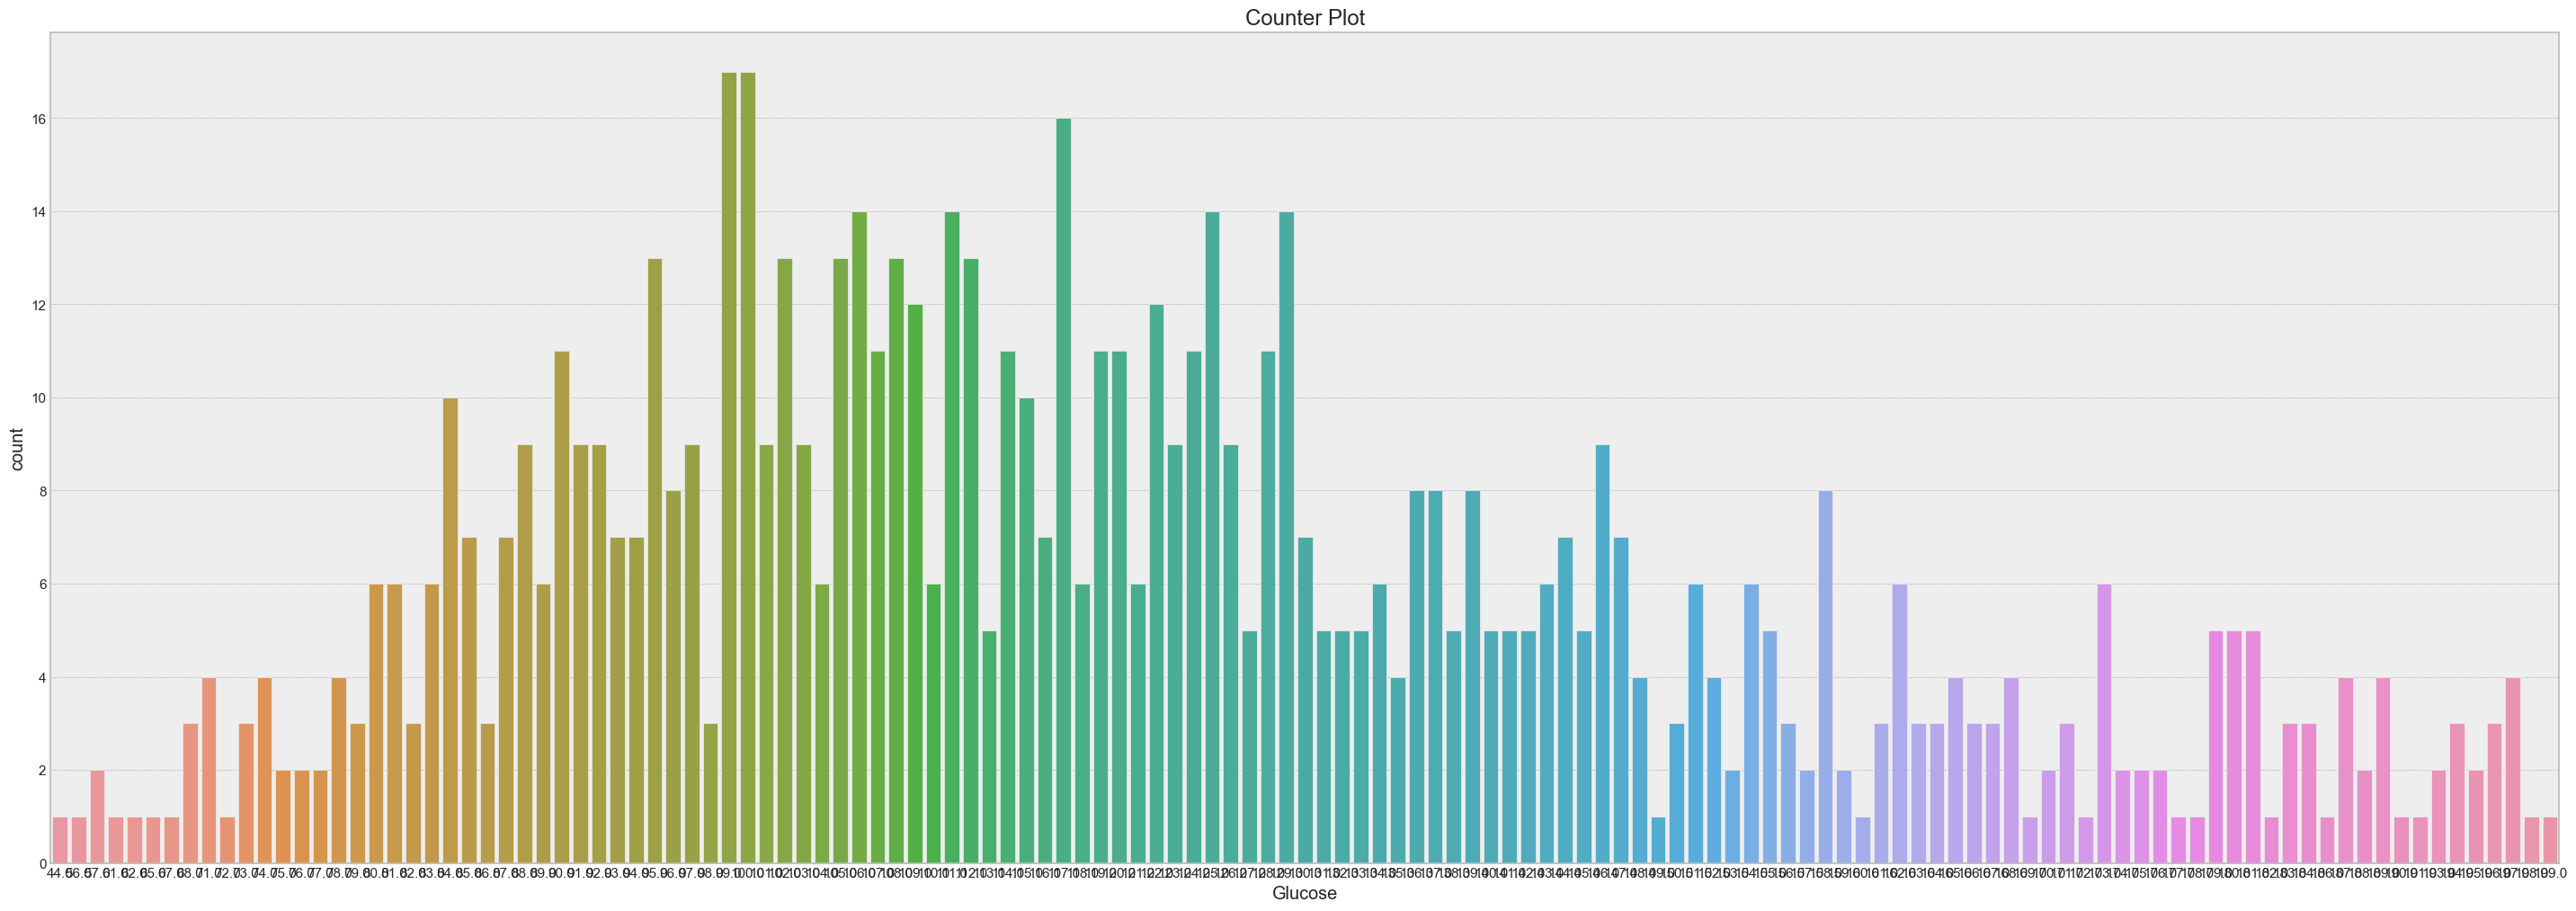

In [11]:
#Glucose
plt.figure(figsize=(36,12))

plt.title("Counter Plot")
sb.countplot(x = 'Glucose',data = data)

plt.show()

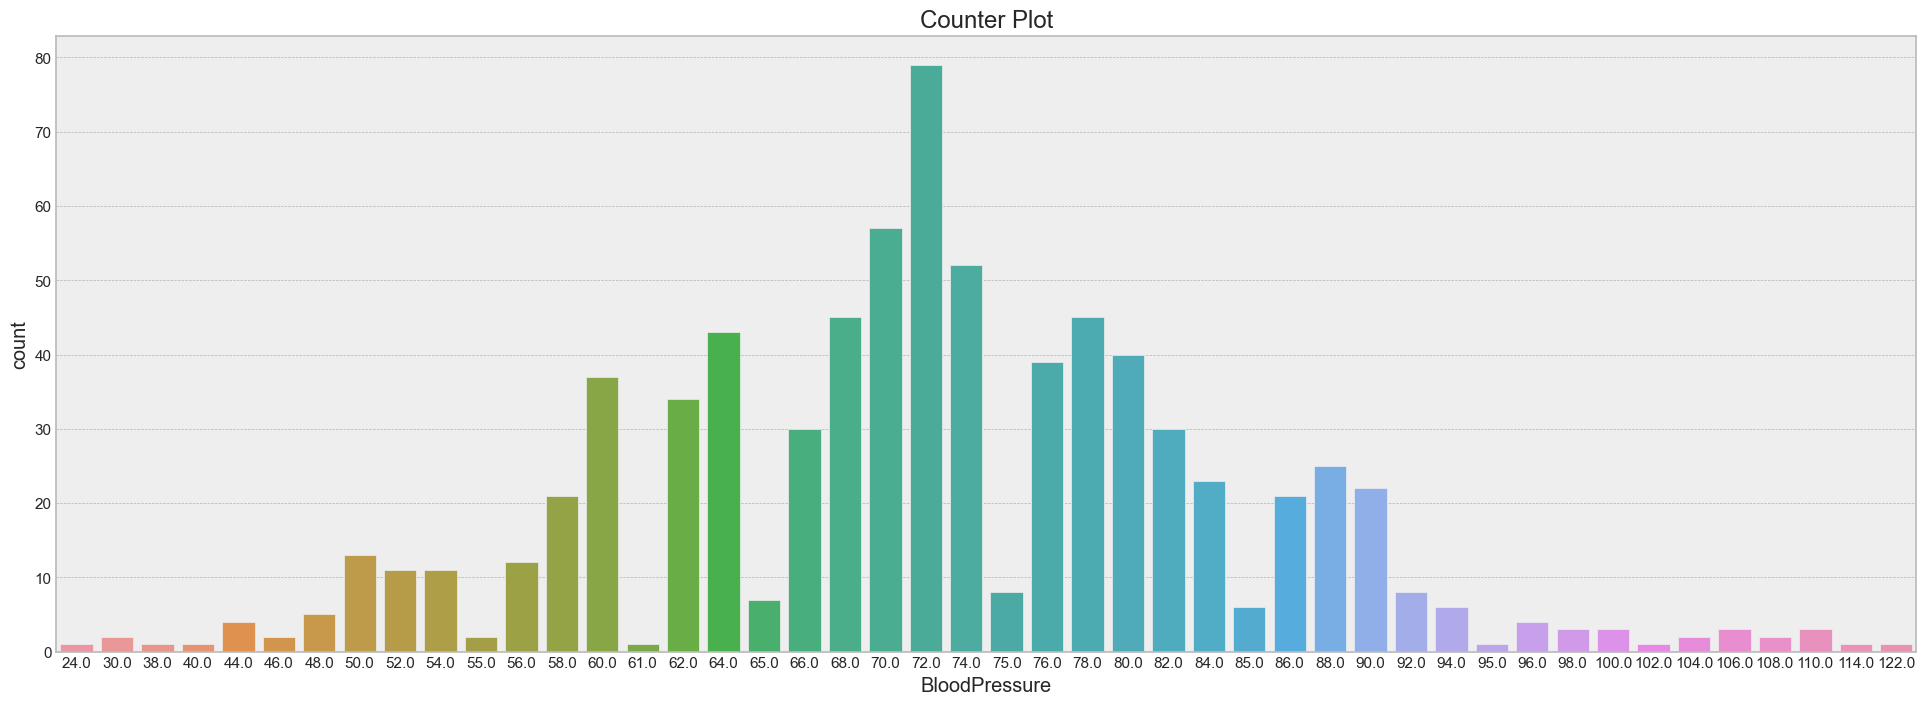

In [12]:
#Blood Pressure
plt.figure(figsize=(24,8))

plt.title("Counter Plot")
sb.countplot(x = 'BloodPressure',data = data)

plt.show()

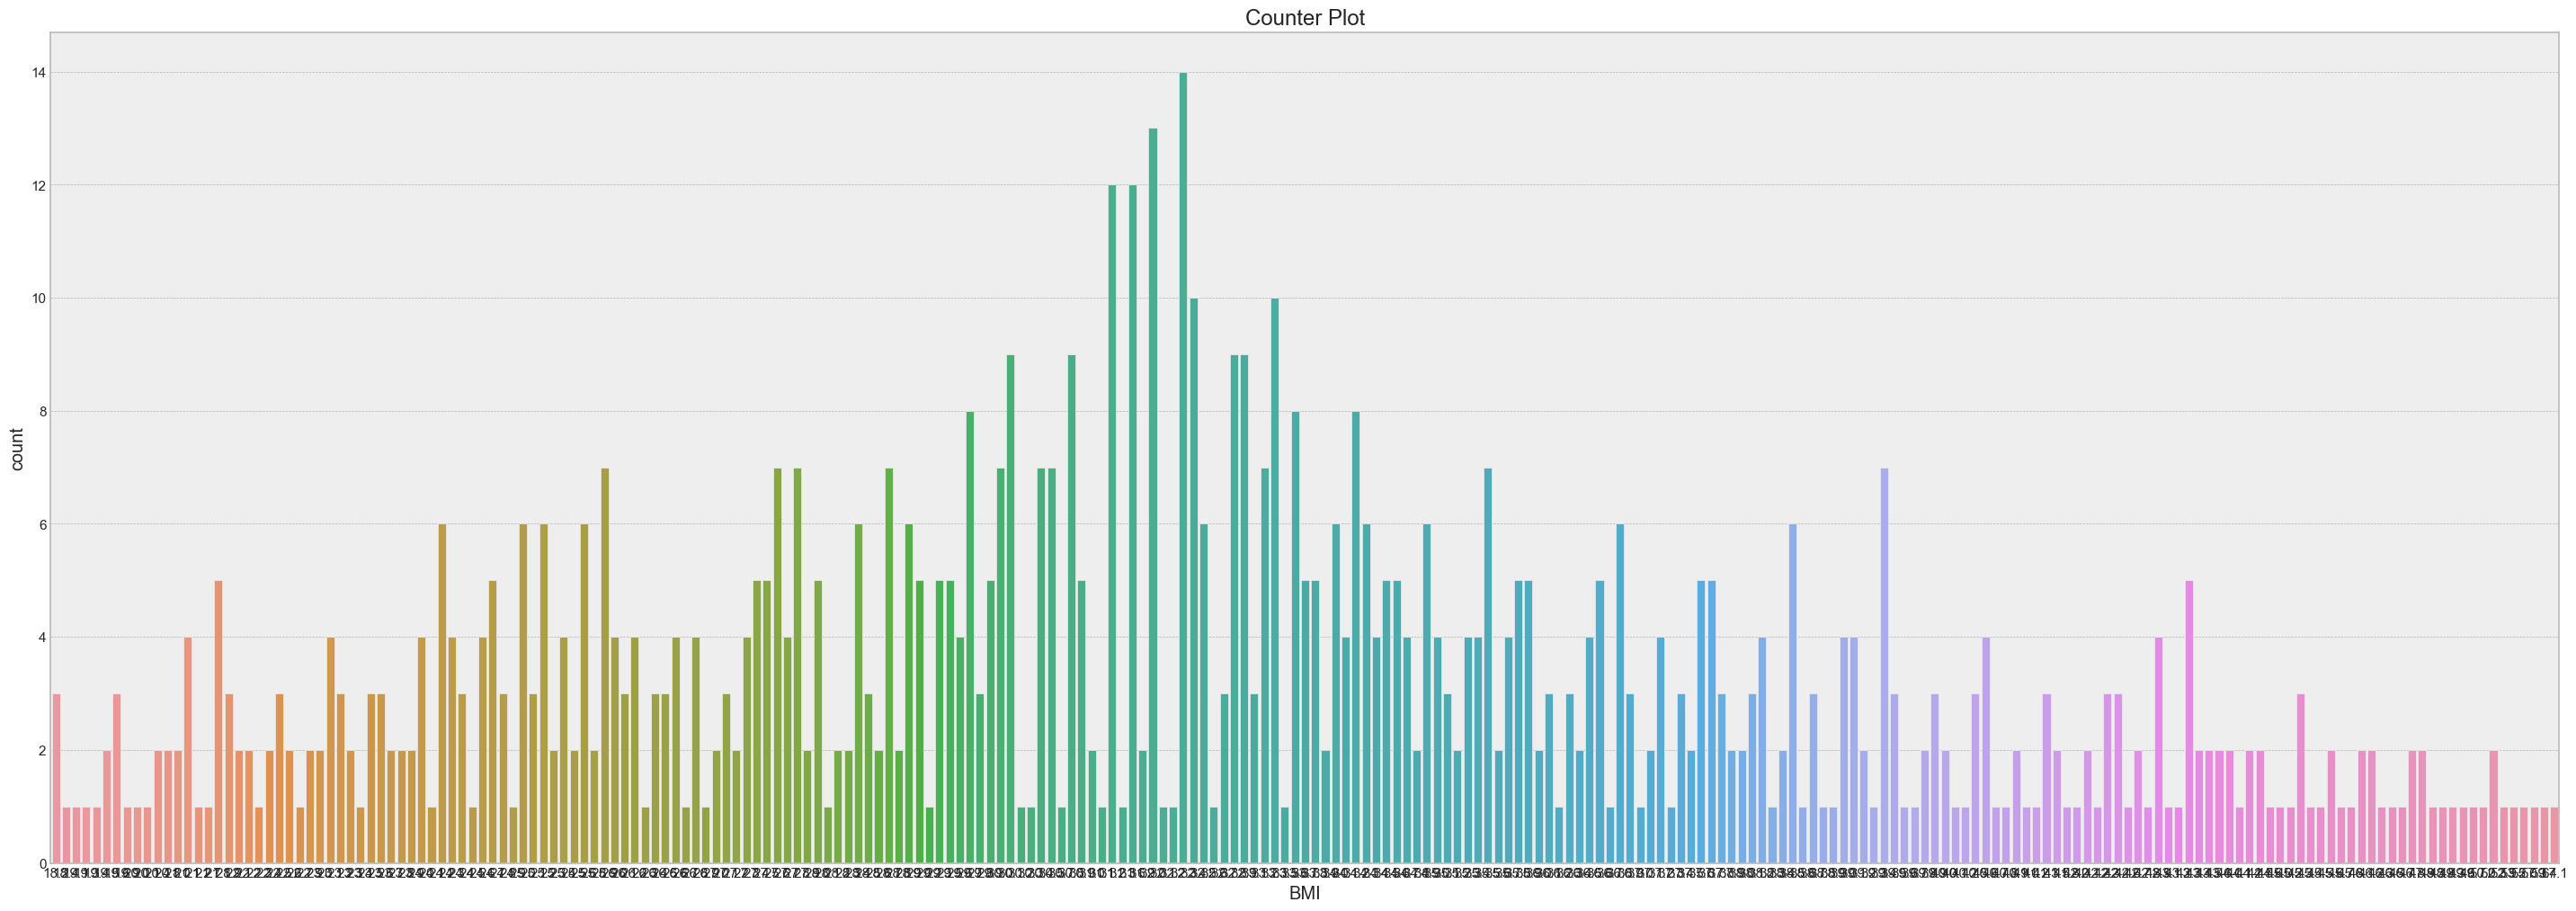

In [13]:
#BMI
plt.figure(figsize=(36,12))

plt.title("Counter Plot")
sb.countplot(x = 'BMI',data = data)

plt.show()

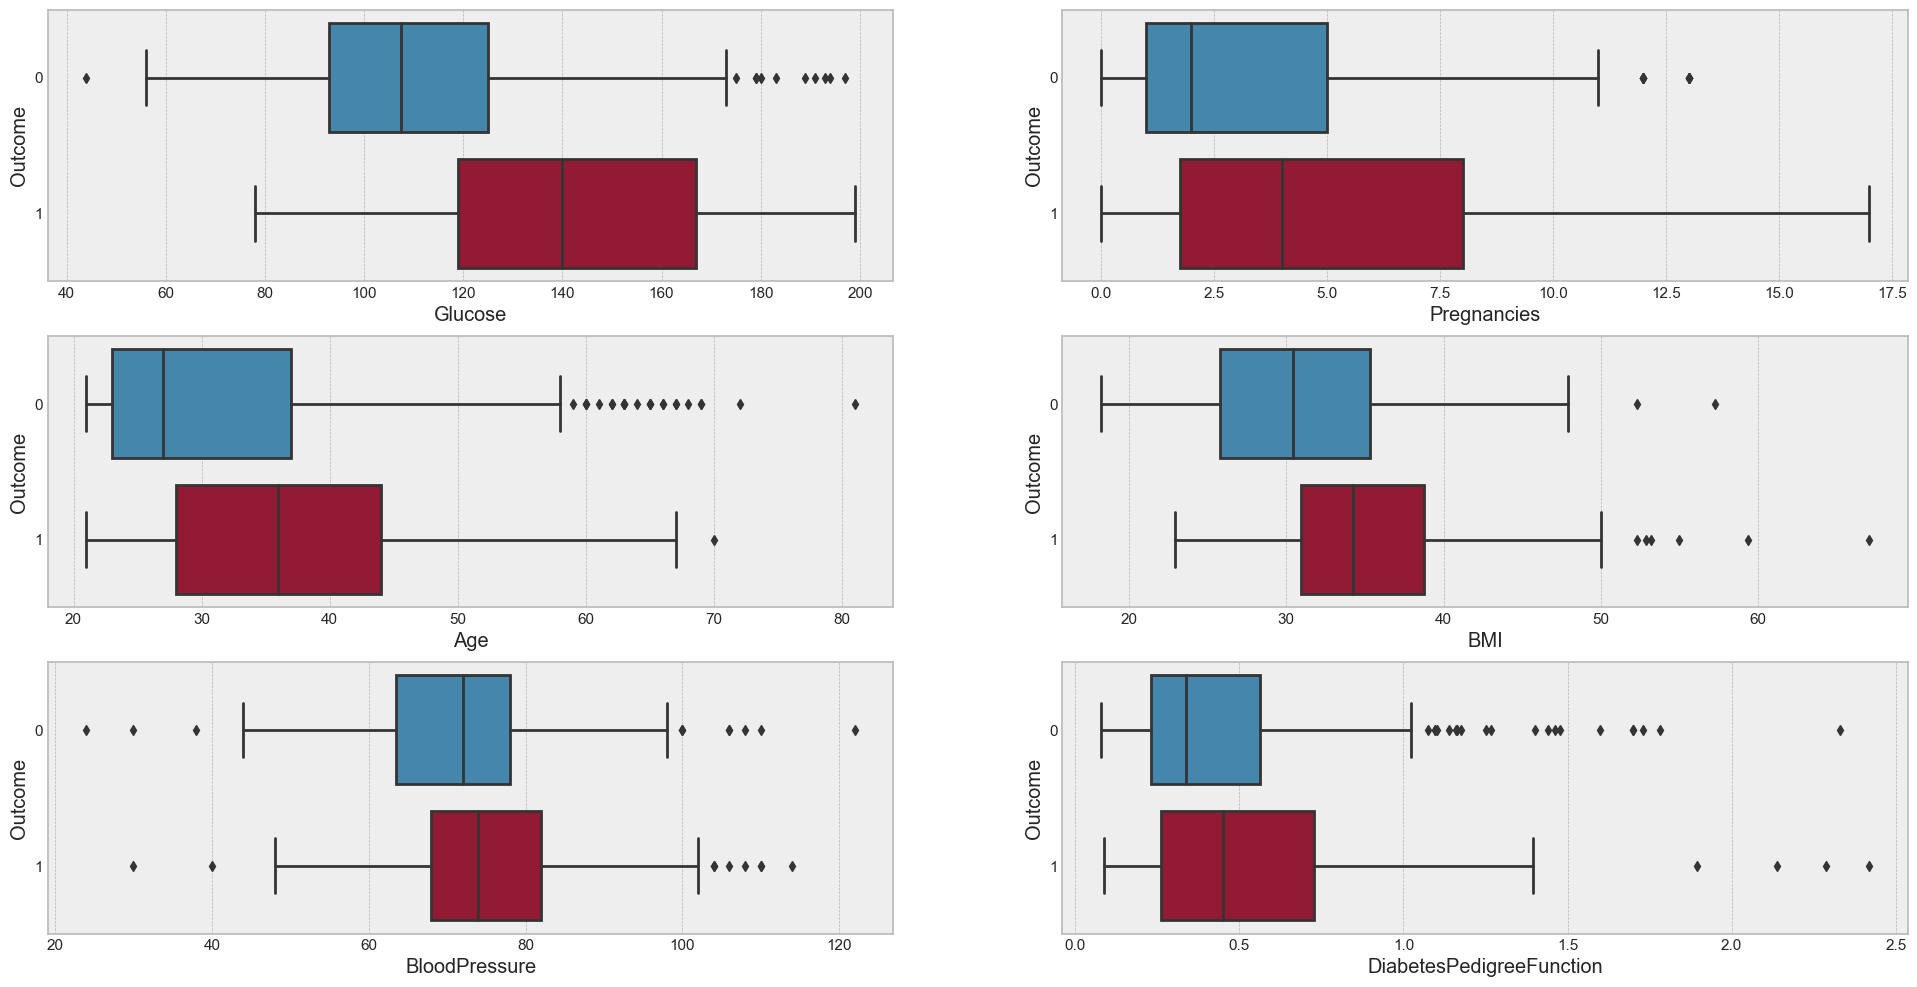

In [14]:
#Categorial Boxplot for Outcome
f, axes = plt.subplots(3, 2, figsize=(24, 12))
sb.boxplot(data= data, x="Glucose", y="Outcome", orient="h", ax = axes[0,0])
sb.boxplot(data= data, x="BMI", y="Outcome", orient="h", ax = axes[1,1])
sb.boxplot(data= data, x="BloodPressure", y="Outcome", orient="h", ax = axes[2,0])
sb.boxplot(data= data, x="Pregnancies", y="Outcome", orient="h", ax = axes[0,1])
sb.boxplot(data= data, x="Age", y="Outcome", orient="h", ax = axes[1,0])
sb.boxplot(data= data, x="DiabetesPedigreeFunction", y="Outcome", orient="h", ax = axes[2,1])
plt.show()

<AxesSubplot:>

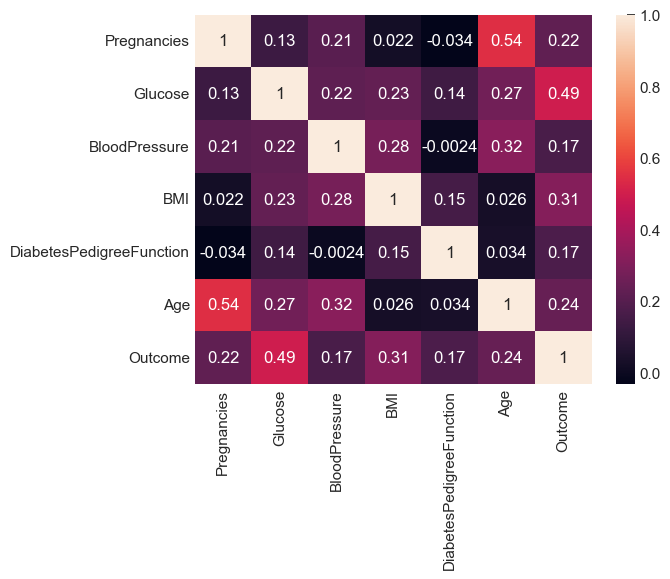

In [15]:
#Correlation Matrix
corr = data.corr()
sb.heatmap(corr,annot=True)

<div class="alert alert-warning">
    <strong>Based on above boxplots, we determine which variable is most suitable to use inside our decision tree classifier.<br>
We chose the variables based on the spread on the boxplot to see which one has the most difference between the outcome.<br>
We chose Glucose, Age, BloodPressure and BMI.</strong>

</div>
